Турчин 1223
### ДЗ 3. Связь бизнес-показателей и DS-метрик

#### Кейс 2 - определение ССЗ

<font color=blue size=4> 
    <hr>
1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта <br>
2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)<br>
3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока<br>
стоимость лечения 15000р, если сделали тест и начали лечить вовремя
стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
стоимость теста 1400р<br>
4. Сделать выводы о том, какая модель справилась с задачей лучше других<br>
*Найти порог классификации по деньгам для лучшей модели
Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
Стоимость теста 1400р
<hr>

<font color=black size=4>  
РЕШЕНИЕ: 
1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv)

In [254]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [255]:
# pip install xgboost

In [256]:
# Загружаем данные
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [257]:
# разделим данные на train/test 
# cardio в роли целевой
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [258]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [259]:
# Теперь объединим все наши трансформеры с помощью FeatureUnion

from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

In [260]:
import warnings
warnings.filterwarnings('ignore')

In [261]:
def take_model(X_train, X_test, y_train, type_model, data_feats):
    '''Функция рассчета predict & metrics для различных моделей '''
    
    classifier = Pipeline([
        ('features', data_feats),
        ('classifier', type_model(random_state=42)),
    ])

    # обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    predict = classifier.predict_proba(X_test)[:, 1]
    
    return predict

In [262]:
def calculate_metrics(model_predict):
    '''Функция рассчета метрик для различных моделей'''
    
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, model_predict)
    fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, model_predict)
#     print(f'Best Threshold={round(thresholds[ix],3)}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}, ROC AUC={roc_auc} ')
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [263]:
xgb.set_config(verbosity=0)

<font color=blue size=4> 
    <hr>
2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
       <hr>

In [264]:
# Для  LogisticRegression
print('Для  LogisticRegression')
model_LogReg_predict = take_model(X_train, X_test, y_train, LogisticRegression, feats)
calculate = calculate_metrics(model_LogReg_predict)
print(f'Best Threshold={round(calculate[0],3)}, F-Score={round(calculate[1],3)}, Precision={round(calculate[2],3)}, Recall={round(calculate[3],3)}, ROC AUC={round(calculate[4],3)}') 
print('----'*5)

print('Для  RandomForestClassifier')
model_RandomForestClassifier = take_model(X_train, X_test, y_train, RandomForestClassifier, feats)
calculate = calculate_metrics(model_RandomForestClassifier)
print(f'Best Threshold={round(calculate[0],3)}, F-Score={round(calculate[1],3)}, Precision={round(calculate[2],3)}, Recall={round(calculate[3],3)}, ROC AUC={round(calculate[4],3)}') 
print('----'*5)

print('Для  XGBoost')
model_XGB_predict = take_model(X_train, X_test, y_train, xgb.XGBClassifier, feats)
calculate = calculate_metrics(model_XGB_predict)
print(f'Best Threshold={round(calculate[0],3)}, F-Score={round(calculate[1],3)}, Precision={round(calculate[2],3)}, Recall={round(calculate[3],3)}, ROC AUC={round(calculate[4],3)}') 
print('----'*5)

print('Для  GRBoost')
model_GRBoost_predict = take_model(X_train, X_test, y_train, GradientBoostingClassifier, feats)
calculate = calculate_metrics(model_GRBoost_predict)
print(f'Best Threshold={round(calculate[0],3)}, F-Score={round(calculate[1],3)}, Precision={round(calculate[2],3)}, Recall={round(calculate[3],3)}, ROC AUC={round(calculate[4],3)}') 
print('----'*5)


Для  LogisticRegression
Best Threshold=0.387, F-Score=0.73, Precision=0.647, Recall=0.838, ROC AUC=0.784
--------------------
Для  RandomForestClassifier
Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816, ROC AUC=0.771
--------------------
Для  XGBoost
Best Threshold=0.34700000286102295, F-Score=0.738, Precision=0.665, Recall=0.828, ROC AUC=0.797
--------------------
Для  GRBoost
Best Threshold=0.395, F-Score=0.74, Precision=0.698, Recall=0.788, ROC AUC=0.803
--------------------


In [265]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
model_ = [model_LogReg_predict, model_RandomForestClassifier, model_XGB_predict, model_GRBoost_predict]
name = ['LogReg', 'RandomForestClassifier', 'XGB', 'GRBoost']
for item in range(4):
    metrics_df = metrics_df.append({
        'model': name[item],
        'thresh': calculate_metrics(model_[item])[0],
        'F-Score': calculate_metrics(model_[item])[1],
        'Precision': calculate_metrics(model_[item])[2],
        'Recall': calculate_metrics(model_[item])[3],
        'ROC AUC': calculate_metrics(model_[item])[4],
    }, ignore_index=True)

metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,LogReg,0.386937,0.730323,0.647431,0.837558,0.784035
1,RandomForestClassifier,0.35,0.718863,0.642669,0.815553,0.771037
2,XGB,0.347103,0.73789,0.665248,0.828341,0.797228
3,GRBoost,0.394947,0.740248,0.697848,0.788134,0.802615


<font color=blue size=4> 
    <hr>
3. Вывести сравнение полученных моделей по метрикам бизнеса <br>
 - стоимость лечения 15000р, если сделали тест и начали лечить вовремя <br>
 - стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы <br>
   - стоимость теста 1400р
       <hr>

Пусть:
- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р

In [267]:
test_rub = 1400
early_treatment_rub = 15000
late_treatment_rub = 20000

Оценим расходы, если применить модели:
(FP + TP) * test_rub - сколько сделали тестов
FN * late_treatment_rub - сколько потратили на лечение необнаруженных заболеваний
TP * early_treatment_rub - сколько потратили на лечение обнаруженных заболеваний (на ранней стадии)

In [268]:
# Надо посчитать для каждой модели 
# ML_rub = (FP + TP) * test_rub + FN * late_treatment_rub + TP * early_treatment_rub
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [269]:
metrics_df_rub = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC', 'Total_rub'])

In [270]:
metrics_df_rub = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC', 'Total_rub'])
model_ = [model_LogReg_predict, model_RandomForestClassifier, model_XGB_predict, model_GRBoost_predict]
name = ['LogReg', 'RandomForestClassifier', 'XGB', 'GRBoost']
for item in range(4):
    
    cnf_matrix = confusion_matrix(y_test, model_[item] > calculate_metrics(model_[item])[0])
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    ML_rub = (FP + TP) * test_rub + FN * late_treatment_rub + TP * early_treatment_rub
    
    metrics_df_rub = metrics_df_rub.append({
        'model': name[item],
        'thresh': calculate_metrics(model_[item])[0],
        'F-Score': calculate_metrics(model_[item])[1],
        'Precision': calculate_metrics(model_[item])[2],
        'Recall': calculate_metrics(model_[item])[3],
        'ROC AUC': calculate_metrics(model_[item])[4],
        'Total_rub': ML_rub
    }, ignore_index=True)

metrics_df_rub

,model,thresh,F-Score,Precision,Recall,ROC AUC,Total_rub
0,LogReg,0.386937,0.730323,0.647431,0.837558,0.784035,152974200
1,RandomForestClassifier,0.35,0.718863,0.642669,0.815553,0.771037,153699400
2,XGB,0.347103,0.73789,0.665248,0.828341,0.797228,152784800
3,GRBoost,0.394947,0.740248,0.697848,0.788134,0.802615,153122800


<font color=blue size=4> 
    <hr>
4. Сделать выводы о том, какая модель справилась с задачей лучше других<br>


#### Судя по таблице лучше справилась модель XGBoost

<font color=blue size=4> 
    <hr>
*Найти порог классификации по деньгам для лучшей модели <br> Стоимость лечения 15000р, если сделали тест и начали лечить вовремя <br>Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы<br> Стоимость теста 1400р
       <hr>




Метрика по деньгам : получить меньше расходов чем при полном тесте

In [271]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 test_rub, early_treatment_rub, late_treatment_rub):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * late_treatment_rub
        rubl_test_all = np.sum(cnf_matrix) * test_rub + (FN + TP) * early_treatment_rub
        rubl_ML = (TP + FP) * test_rub + FN * late_treatment_rub + TP * early_treatment_rub
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152509800
Расходы "решение не делать тесты - расходы с МL:" 21090200
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 2190200


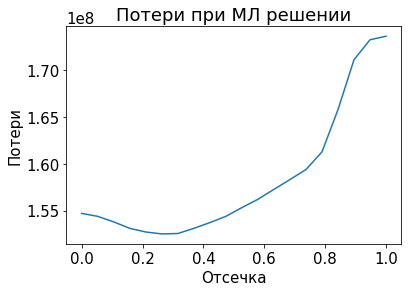

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.39494659702686624


In [272]:
busines_tr = business_threshold_calibrate(y_test, model_XGB_predict, 
                                          calculate_metrics(model_XGB_predict)[0],
                                          test_rub=1400, 
                                          early_treatment_rub=15000, 
                                          late_treatment_rub=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', calculate_metrics(model_[item])[0])